## _*H2 dissociation curve using VQE with UCCSD*_

This notebook demonstrates using Qiskit Chemistry to plot graphs of the ground state energy of the Hydrogen (H2) molecule over a range of inter-atomic distances using VQE and UCCSD. It is compared to the same energies as computed by the NumPyMinimumEigensolver. `UCCSD` should be used together with `HartreeFock` initial state.

In [1]:
import numpy as np
import pylab

from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.formats import MoleculeInfo
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.algorithms import GroundStateEigensolver

from qiskit_algorithms import NumPyMinimumEigensolver

from qiskit_algorithms.optimizers import SLSQP

from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_algorithms import VQE

from qiskit.primitives import Estimator

In [13]:
distances  = [0.5 + 0.025*x  for x in range(0, 20)]

def compute_energies(algorithm, distances):
    print(f'{algorithm}, processing step __', end='')

    energies = []
    hf_energies = []
    estimator = Estimator()

    for i, d in enumerate(distances):
        print('\b\b{:2d}'.format(i), end='', flush=True)

        info = MoleculeInfo(["H", "H"], [(0.0, 0.0, 0.0), (0.0, 0.0, d)])
        driver = PySCFDriver.from_molecule(info, basis="sto3g")
        molecule = driver.run()
        mapper = JordanWignerMapper()
        tapered_mapper = molecule.get_tapered_mapper(mapper)

        if algorithm == 'NumPyMinimumEigensolver':
            algo = NumPyMinimumEigensolver()
            algo.filter_criterion = molecule.get_default_filter_criterion()
            solver = GroundStateEigensolver(mapper, algo)
            result = solver.solve(molecule)
            hf_energies.append(result.hartree_fock_energy)
            energies.append(result.total_energies[0])

        elif algorithm == 'VQE':
            optimizer = SLSQP(maxiter=10000, ftol=1e-9)
            ansatz = UCCSD(
                molecule.num_spatial_orbitals,
                molecule.num_particles,
                tapered_mapper,
                initial_state=HartreeFock(
                    molecule.num_spatial_orbitals,
                    molecule.num_particles,
                    tapered_mapper,
                ),
            )
            vqe = VQE(estimator, ansatz, optimizer)
            algo = GroundStateEigensolver(tapered_mapper, vqe)
            result = algo.solve(molecule)
            energies.append(result.total_energies[0])
            hf_energies.append(result.hartree_fock_energy)

    print(' --- complete')
    return hf_energies, energies

In [14]:
hf_energies, npme_energies = compute_energies('NumPyMinimumEigensolver', distances)
_, vqe_energies = compute_energies('VQE', distances)

NumPyMinimumEigensolver, processing step 19 --- complete
VQE, processing step 19 --- complete


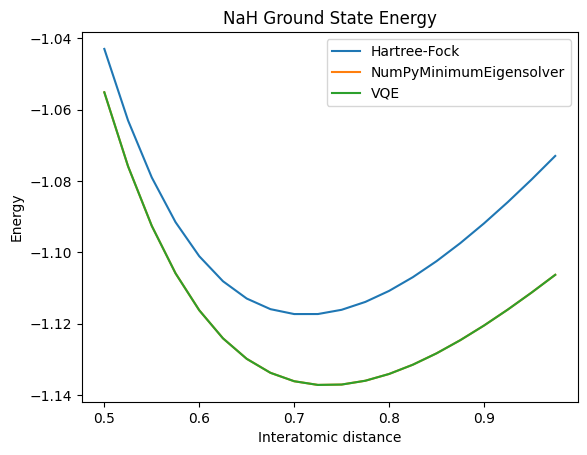

In [15]:
pylab.plot(distances, hf_energies, label='Hartree-Fock')
pylab.plot(distances, npme_energies, label='NumPyMinimumEigensolver')
pylab.plot(distances, vqe_energies, label='VQE')
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('NaH Ground State Energy')
pylab.legend(loc='upper right')

In [5]:
print(f"""HF bond distance: {distances[hf_energies.index(min(hf_energies))]:.2f} A, energy: {min(hf_energies):.3f} Ha
VQE bond distance: {distances[vqe_energies.index(min(vqe_energies))]:.2f} A, energy: {min(vqe_energies):.3f} Ha
NumpyMinimumEigensolver bond distance: {distances[npme_energies.index(min(npme_energies))]:.2f} A, energy: {min(npme_energies):.3f} Ha""")

HF bond distance: 0.70 A, energy: -1.117 Ha
VQE bond distance: 0.72 A, energy: -1.137 Ha
NumpyMinimumEigensolver bond distance: 0.72 A, energy: -1.137 Ha


In [6]:
! pip freeze | grep qiskit

qiskit==1.1.0
qiskit-aer==0.14.2
qiskit-algorithms==0.3.0
qiskit-ibm-runtime==0.25.0
qiskit-machine-learning==0.7.2
qiskit-nature==0.7.2
qiskit-nature-pyscf==0.4.0
qiskit-qasm3-import==0.5.0
qiskit-transpiler-service==0.4.5
